# Import

In [1]:
# Клонируем репозитерий stylegan2-ada-pytorch
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git /content/stylegan2-ada-pytorch

fatal: destination path '/content/stylegan2-ada-pytorch' already exists and is not an empty directory.


In [2]:
# Скачиваем модель StyleGAN2
!mkdir -p /content/StyleGAN2
!wget -q https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl -O /content/StyleGAN2/ffhq.pkl # модель обученная на датасете ffhq(лица)

In [3]:
!pip install -q git+https://github.com/openai/CLIP.git # установка CLIP
!pip install -q ninja # утилита для сборки C++/CUDA кода
!pip install -q youtokentome # библиотека от Яндекса для работы с BPE-токенизатором

  Preparing metadata (setup.py) ... done


In [2]:
import sys
import os
sys.path.append('/content/stylegan2-ada-pytorch')
os.environ['TORCH_CUDA_ARCH_LIST'] = '7.5'

import pickle
import copy

import numpy as np

import clip

import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast

from torchvision.utils import make_grid, save_image
from torchvision.transforms import transforms

from PIL import Image
import matplotlib.pyplot as plt

import re

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

RAND = 2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
torch.cuda.manual_seed(RAND)

In [ ]:
# Загружаем свое фото
#image =Image.open('/content/kot.jpg')

#plt.figure(figsize=(8,8))
#plt.imshow(image)
#plt.axis('off')
#plt.show()

# Utils

In [4]:
def cleaned_text(text) -> str:
    """
    Простая очистка текста.
    """
    text = str(text) if text is not None else '' # преобразование text в строку, если это не строка
    text = text.lower()
    text = re.sub(r'[^а-яёa-z0-9\s.,*!?:-]', '', text)  # удаление лишних символов (кроме пунктуации)
    text = re.sub(r'\s+', ' ', text).strip()  # удаление лишних пробелов
    text = re.sub(r'^[^\w]+', '', text)  # удаление пунктуации в начале строки
    text = text.strip(' .')  # убирает лишние пробелы и точки в начале и в конце строки
    return text

In [5]:
def preprocessing_text(model,
                       text: str,
                       device: torch.device) -> torch.Tensor:
  """
  Делает простую очистку текста, токенизирует и возвращает эмбеддинги.

  :param model: модель CLIP
  :param text: входной текст
  :param device: устройство для вычислений (CPU или CUDA)

  :return: эмбеддинг текста в пространстве CLIP
  """
  model.eval()
  with torch.no_grad():
    text = cleaned_text(text)
    text_tokenize = clip.tokenize(text).to(device)
    text_features = model.encode_text(text_tokenize)

  return text_features.detach()

In [6]:
def preprocessing_image(model,
                        preprocess_image,
                        image,
                        device: torch.device) -> torch.Tensor:
    """
    Если image - torch.Tensor, то преобразует его в PIL.
    Если image — PIL.Image, используется стандартный CLIP-препроцессор.
    Возвращает эмбеддинг изображения.

    :param model: модель CLIP
    :param preprocess_image: препроцессор модели CLIP для изображения
    :param image: входное изображение
    :param device: устройство для вычислений (CPU или CUDA)

    :return: эмбеддинг изображения в пространстве CLIP
    """
    model.eval()
    if isinstance(image, torch.Tensor):
      # Для torch.Tensor из StyleGAN2 с диапазоном [-1,1]
      transform = transforms.Compose([
          transforms.Lambda(lambda x: ((x + 1) / 2).clamp(0, 1)),
          transforms.Lambda(lambda x: F.interpolate(x,
                                                    size=(224, 224),
                                                    mode='bilinear',
                                                    align_corners=False)),
          transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                               std=(0.26862954, 0.26130258, 0.27577711))])

      image_preproc = transform(image.to(device))

      #image = ((image + 1) / 2).clamp(0, 1) # [-1, 1] → [0, 1]
      #image = (image * 255).to(torch.uint8) # конвертируем в диапазон [0, 255] и в тип uint8
      #image = image.permute(0, 2, 3, 1).cpu().numpy() # меняем формат с CHW → HWC и преобразуем в np.array
      #image = [Image.fromarray(img) for img in image] # cоздаём PIL.Image
      #image_preproc = torch.stack([preprocess(img) for img in image]).to(device)
    else:
      # Для PIL-изображений
      image_preproc = preprocess_image(image).unsqueeze(0).to(device)

    image_features = model.encode_image(image_preproc)

    return image_features

In [7]:
def extract_patches(image: torch.Tensor,
                    patch_size: int=64,
                    num_patches: int=8):
    """
    Извлекает случайные патчи из изображения.

    :param image: тензор [B, C, H, W]
    :param patch_size: размер квадрата патча
    :param num_patches: количество патчей

    :return: тензор [B*num_patches, C, patch_size, patch_size]
    """
    B, C, H, W = image.shape
    patches = []
    for _ in range(num_patches):
        i = torch.randint(0, H - patch_size, (1,)).item()
        j = torch.randint(0, W - patch_size, (1,)).item()
        patch = image[:, :, i:i+patch_size, j:j+patch_size]
        patches.append(patch)
    return torch.cat(patches, dim=0)

In [8]:
def make_latents(G,
                 RAND: int,
                 device: torch.device):
  """
  Герерирует латенты.

  :param G: генератор, используется для определение размера вектора
  :param RAND: фиксирует генератор случайных чисел
  :param device: устройство для вычислений (CPU или CUDA)

  :return: два латента (latent, latent_sample)
  """
  torch.cuda.manual_seed(RAND)
  latent_sample = torch.randn(4, G.z_dim, device=device)
  latent = torch.randn(2, G.z_dim, device=device)
  latent_plus = torch.randn(8, G.z_dim, device=device)
  return latent_sample, latent, latent_plus

# StyleGN2-ADA

In [9]:
with open('/content/StyleGAN2/ffhq.pkl', 'rb') as f:
  G = pickle.load(f)['G_ema'].to(device)

G_frozen = copy.deepcopy(G) # копия генератора (замороженный)

In [11]:
latent_sample, latent, latent_plus = make_latents(G,
                                                  RAND=RAND,
                                                  device=device)

c = None
G.eval()
image_gan = G(latent_sample,
              c,
              truncation_psi=0.7,
              noise_mode='const')

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [ ]:
img = ((image_gan +  1) / 2).clamp(0, 1)  # [-1, 1] → [0, 1]
grid = make_grid(img, nrow=2)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.axis('off')
plt.show()

# CLIP

In [10]:
# Загружаем модель и процессор
model, preprocess = clip.load('ViT-B/32', device=device)

In [15]:
text_features = preprocessing_text(model, 'woman', device)

In [16]:
image_features = preprocessing_image(model, preprocess, image_gan, device)

# Train

## Loss

### cosine_dist

In [11]:
def cosine_dist(image_features: torch.Tensor,
                text_features: torch.Tensor) -> torch.Tensor:
 """
 Вычисляет глобальный CLIP-loss (cosine distance).

 :param image_features: вектора изображения в пространстве CLIP
 :param text_features: вектора текста в пространстве CLIP

 :return: косинусное расстояние
 """
 global_loss = 1 - F.cosine_similarity(image_features, text_features, dim=-1)
 return global_loss.mean()

### clip_loss

In [12]:
def delta_text(model,
               text_target: str,
               text_source: str,
               device: torch.device) -> torch.Tensor:
  """
  Вычисляет вектор текстового направления между таргетом и текущим стилем.

  :param model: модель CLIP
  :param text_target: текст целевого стиля
  :param text_source: текст исходного стиля
  :param device: устройство для вычислений (CPU или CUDA)

  :return: вектор текстового направления
  """
  emb_delta_text = preprocessing_text(model,
                                      text_target,
                                      device) - preprocessing_text(model,
                                                                   text_source,
                                                                   device)
  return emb_delta_text

In [13]:
def delta_image(model,
                preprocess_image,
                image: torch.Tensor,
                image_frozen: torch.Tensor,
                device: torch.device) -> torch.Tensor:
  """
  Вычисляет вектор визуального направления между изображением до и после fine-tuning.
  :param model: модель CLIP
  :param preprocess_image: препроцессор модели CLIP для изображения
  :param image: изображение из обучаемого генератора
  :param image_frozen: изображение из замороженного генератора
  :param device: устройство для вычислений (CPU или CUDA)

  :return: вектор визуального направления
  """

  emb_delta_image = preprocessing_image(model,
                                        preprocess_image,
                                        image,
                                        device) - preprocessing_image(model,
                                                                      preprocess_image,
                                                                      image_frozen,
                                                                      device)
  return emb_delta_image

In [14]:
def clip_loss(delta_image: torch.Tensor,
              delta_text: torch.Tensor) -> torch.Tensor:
  """
  Вычисляет направленный CLIP-loss.

  :param delta_image: вектор визуального направления
  :param delta_text: вектор текстового направления

  :return: направленный CLIP-loss (скаляр)
  """

  direction_clip_loss = 1 - F.cosine_similarity(delta_image, delta_text, dim=-1)
  return direction_clip_loss.mean()

## Train

### cosine_dist

In [ ]:
def train_generator(generator,
                    model,
                    preprocess_image,
                    text: str,
                    epochs: int,
                    criterion,
                    device: torch.device,
                    RAND: int=2,
                    batch_size: int=2,
                    sample_size: int=4,
                    lr: float=0.0003,
                    c: torch.Tensor=None):
  """
  Обучает генератор StyleGAN2 для изменения изображений в направлении текста
  с использованием косинусного расстояния в качестве функции потерь.

  Функция выполняет fine-tuning генератора на фиксированном латентном векторе,
  вычисляет эмбеддинги изображения и текста через CLIP и минимизирует
  косинусное расстояние между ними, чтобы стилизовать изображение под заданный текст.

  Каждые 50 эпох сохраняет сгенерированные изображения.
  В конце визуализирует поведение функции потерь.

  :param generator: генератор StyleGAN2, который будет обучаться
  :param model: модель CLIP для получения текстовых и визуальных эмбеддингов
  :param preprocess_image: функция препроцессинга изображений для CLIP
  :param text: целевой текстовый промпт, определяющий желаемый стиль изображения
  :param epochs: количество эпох обучения генератора
  :param criterion: функция потерь, которая принимает текстовые и визуальные эмбеддинги и возвращает скалярный loss
  :param device: устройство для вычислений (CPU или CUDA)
  :param RAND: фиксирует генератор случайных чисел
  :param batch_size: размерность батча для обучения
  :param sample_size: размерность генерируемого сэмпла
  :param lr: скорость обучения для оптимизатора
  :param c: условие для генератора

  :return: None
  """
  loss_lst = []

  torch.cuda.manual_seed(RAND)
  os.makedirs('results', exist_ok=True)

  latent_sample = torch.randn(sample_size, generator.z_dim, device=device)
  latent = torch.randn(batch_size, generator.z_dim, device=device)

  optimizer = torch.optim.AdamW(generator.parameters(), lr=lr)

  generator.train()
  for param in generator.parameters():
    param.requires_grad = True

  for i in tqdm(range(epochs)):
    torch.cuda.empty_cache()
    optimizer.zero_grad()

    image = generator(latent, c, truncation_psi=0.7, noise_mode='const')

    text_features = preprocessing_text(model,
                                       text,
                                       device)
    image_features = preprocessing_image(model,
                                         preprocess,
                                         image,
                                         device)

    loss = criterion(text_features, image_features)
    loss.backward()
    optimizer.step()

    loss_lst.append(loss.item())

    torch.cuda.empty_cache()

    print(f'Эпоха {i + 1}: loss={loss.item():.4f}')

    if i % 50 == 0:
      image_sample = generator(latent_sample,
                               c,
                               truncation_psi=0.7,
                               noise_mode='const')
      img = (image_sample.clamp(-1, 1) + 1) / 2.0  # [-1, 1] → [0, 1]
      grid = make_grid(img, nrow=2)

      save_path = f'results/generated_image_epoch_{i}.jpg'
      save_image(grid, save_path, 'jpeg')

      plt.figure(figsize=(8, 8))
      plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
      plt.axis('off')
      plt.show()

  plt.figure(figsize=(8, 8))
  plt.plot(loss_lst)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('График лосса')
  plt.grid(True)
  plt.show()

In [ ]:
train_generator(generator=G,
                model=model,
                preprocess_image=preprocess,
                text='werewolf',
                epochs=301,
                criterion=cosine_dist,
                device=device,
                RAND=2,
                batch_size=2,
                sample_size=4,
                lr=0.0003,
                c=None)

### clip_loss

In [15]:
def train_generator(generator,
                    generator_frozen,
                    model,
                    preprocess_image,
                    text_source: str,
                    text_target: str,
                    epochs: int,
                    criterion,
                    device: torch.device,
                    RAND: int=2,
                    batch_size: int=2,
                    sample_size: int=4,
                    batch_size_w: int=8,
                    lr: float=0.002,
                    lr_w: float=0.02,
                    k: int=12,
                    lambda_reg: float=0.1,
                    max_norm: float=1.0,
                    c: torch.Tensor=None):
  """
  Обучает генератор StyleGAN2 для изменения изображений в направлении текста
  с использованием CLIP-косинусного расстояния в качестве функции потерь.

  Функция выполняет fine-tuning генератора на фиксированном латентном векторе,
  вычисляет векторное направление между изображениями до и после обучения
  и текстовыми эмбеддингами, и минимизирует косинусное расстояние между ними.

  Каждые 50 эпох сохраняет сгенерированные изображения.
  В конце визуализирует график лосса.

  :param generator: генератор StyleGAN2, который будет обучаться
  :param generator_frozen: замороженный генератор, используемый для вычисления delta_image
  :param model: модель CLIP для получения текстовых и визуальных эмбеддингов
  :param preprocess_image: функция препроцессинга изображений для CLIP
  :param text_source: исходный текстовый промпт
  :param text_target: целевой текстовый промпт
  :param epochs: количество эпох обучения генератора
  :param criterion: функция потерь, которая принимает delta_image и delta_text и возвращает скалярный loss
  :param device: устройство для вычислений (CPU или CUDA)
  :param RAND: фиксирует генератор случайных чисел
  :param batch_size: размерность батча для обучения
  :param sample_size: размерность генерируемого сэмпла
  :param batch_size_w: размерность батча для оптимизации векторов из пространства W+
  :param lr: скорость обучения для оптимизатора параметров генератора
  :param lr_w: скорость обучения для оптимизатора векторов из пространства W+
  :param k: количество слоев которые обучаются
  :param lambda_reg: коэффициент регуляризации
  :param max_norm: максимальная норма градиентов
  :param c: условие для генератора

  :return: None
  """
  loss_lst = []

  torch.cuda.empty_cache()
  torch.cuda.manual_seed(RAND)
  os.makedirs('results', exist_ok=True)

  latent_sample = torch.randn(sample_size, generator.z_dim, device=device)
  latent = torch.randn(batch_size, generator.z_dim, device=device)
  latent_plus = torch.randn(batch_size_w, generator.z_dim, device=device)

  generator = generator.to(device)
  generator_frozen = generator_frozen.to(device)
  generator.train()
  generator_frozen.eval()

  lst_block = []
  for name, module in generator.synthesis.named_children():
    if name.startswith('b'):
        lst_block.append(name)

  # Заморозка всего generator_frozen
  for param in generator_frozen.parameters():
    param.requires_grad = False

  # Заморозка mapping generator
  for param in generator.mapping.parameters():
    param.requires_grad = False

  for epoch in tqdm(range(epochs)):

    # Оптимизация векторов из пространства W+
    w_plus_source = generator.mapping(latent_plus,
                                      c) # [batch_size, num_layers, dim]
    w_plus_target = generator.mapping(latent_plus,
                                      c) # [batch_size, num_layers, dim]
    w_plus_target = w_plus_target.clone().requires_grad_(True)

    optimizer_w_plus = torch.optim.Adam([w_plus_target], lr=lr_w)

    optimizer_w_plus.zero_grad()

    image_w_plus = generator.synthesis(w_plus_target,
                                      noise_mode='const')


    image_w_plus_features = preprocessing_image(model,
                                                preprocess,
                                                image_w_plus,
                                                device)

    text_w_plus_features = preprocessing_text(model,
                                              text_target,
                                              device)

    loss_w_plus = cosine_dist(image_w_plus_features,
                              text_w_plus_features)

    loss_w_plus.backward()

    # Ограничивает норму градиентов
    torch.nn.utils.clip_grad_norm_([w_plus_target], max_norm=max_norm)

    optimizer_w_plus.step()

    torch.cuda.empty_cache()

    delta_w_plus = w_plus_target.detach() - w_plus_source.detach()
    #delta_w_plus_normed = delta_w_plus / (delta_w_plus.norm(p=2, dim=-1, keepdim=True) + 1e-8)
    delta_norm = delta_w_plus.norm(p=2, dim=-1).mean(dim=0)

    topk_indices = torch.topk(delta_norm, k).indices

    # Заморозка synthesis
    for p in generator.synthesis.parameters():
      p.requires_grad = False

    # Заморозка affine и torgb параметров
    #for name, module in generator.synthesis.named_modules():
    #  lname = name.lower()
    #  if 'affine' in lname or 'torgb' in lname:
    #    for p in module.parameters():
    #      p.requires_grad = False

    # Заморозка всех слоев кроме топ-k
    for ind in topk_indices:
      block_idx = ind // 2
      conv_num = ind % 2

      block_name = lst_block[block_idx]
      block = getattr(generator.synthesis, block_name)

      if block_name == 'b4':
        block.conv1.weight.requires_grad = True
        block.conv1.bias.requires_grad = True
        #for p in conv.parameters():
        #    p.requires_grad = True
      else:
        if conv_num == 0:
          block.conv0.weight.requires_grad = True
          block.conv0.bias.requires_grad = True
        else:
          block.conv1.weight.requires_grad = True
          block.conv1.bias.requires_grad = True
        #for p in conv.parameters():
        #  p.requires_grad = True

    train_params = [param for param in generator.parameters() if param.requires_grad]
    optimizer = torch.optim.Adam(train_params, lr=lr)

    optimizer.zero_grad()

    image = generator(latent,
                      c,
                      truncation_psi=0.7,
                      noise_mode='const')

    with torch.no_grad():
      image_frozen = generator_frozen(latent,
                                      c,
                                      truncation_psi=0.7,
                                      noise_mode='const')

    emb_delta_image = delta_image(model,
                                  preprocess_image,
                                  image,
                                  image_frozen,
                                  device)

    emb_delta_text = delta_text(model,
                                text_target,
                                text_source,
                                device)

      #reg_loss = 0.0
      #for p_frozen, p in zip(generator_frozen.synthesis.parameters(),
      #                       generator.synthesis.parameters()):
      #  if p.requires_grad == True:
      #    reg_loss += (p_frozen - p).pow(2).sum()

    # Извлекаюися патчи
    patches = extract_patches(image,
                              patch_size=64,
                              num_patches=8)
    patches_frozen = extract_patches(image_frozen,
                                    patch_size=64,
                                    num_patches=8)

    emb_patches = preprocessing_image(model,
                                      preprocess_image,
                                      patches,
                                      device)
    emb_patches_frozen = preprocessing_image(model,
                                            preprocess_image,
                                            patches_frozen,
                                            device)

    patch_loss = cosine_dist(emb_patches,
                             emb_patches_frozen)

    loss = criterion(emb_delta_image,
                    emb_delta_text)

    loss += lambda_reg * patch_loss

    loss.backward()

    # Ограничивает норму градиентов
    torch.nn.utils.clip_grad_norm_(train_params, max_norm=max_norm)

    optimizer.step()

    loss_lst.append(loss.item())

    torch.cuda.empty_cache()

    print(f'Эпоха {epoch + 1}: loss={loss.item():.4f}')

    if epoch % 50 == 0:
      image_sample = generator(latent_sample,
                               c,
                               truncation_psi=0.7,
                               noise_mode='const')
      img = (image_sample.clamp(-1, 1) + 1) / 2.0  # [-1, 1] → [0, 1]
      grid = make_grid(img, nrow=2)

      save_path = f'results/generated_image_epoch_{epoch}.jpg'
      save_image(grid, save_path, 'jpeg')

      plt.figure(figsize=(8, 8))
      plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
      plt.axis('off')
      plt.show()

  plt.figure(figsize=(8, 8))
  plt.plot(loss_lst)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('График лосса')
  plt.grid(True)
  plt.show()

  0%|          | 0/301 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Эпоха 1: loss=0.9897


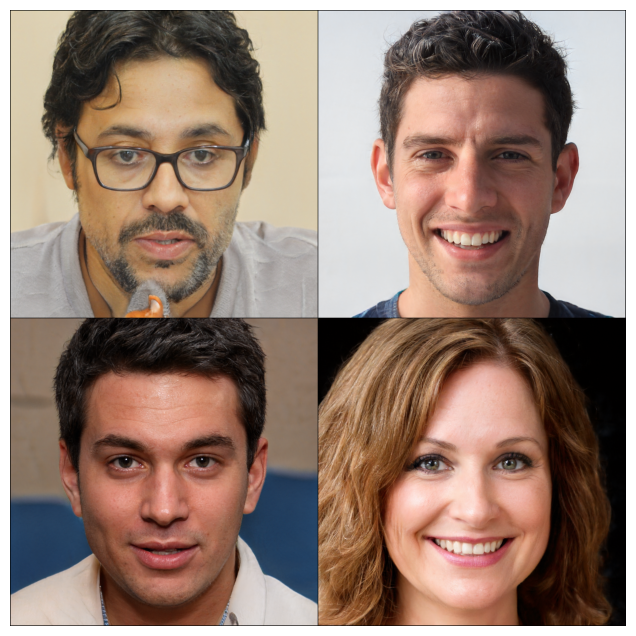

Эпоха 2: loss=0.8560
Эпоха 3: loss=0.8286
Эпоха 4: loss=0.8232
Эпоха 5: loss=0.8130
Эпоха 6: loss=0.7671
Эпоха 7: loss=0.7710
Эпоха 8: loss=0.7754
Эпоха 9: loss=0.7505
Эпоха 10: loss=0.7593
Эпоха 11: loss=0.7183
Эпоха 12: loss=0.7090
Эпоха 13: loss=0.7637
Эпоха 14: loss=0.7466
Эпоха 15: loss=0.6958
Эпоха 16: loss=0.6812
Эпоха 17: loss=0.7559
Эпоха 18: loss=0.7173
Эпоха 19: loss=0.6909
Эпоха 20: loss=0.7104
Эпоха 21: loss=0.6602
Эпоха 22: loss=0.6621
Эпоха 23: loss=0.6860
Эпоха 24: loss=0.6602
Эпоха 25: loss=0.7124
Эпоха 26: loss=0.6641
Эпоха 27: loss=0.6636
Эпоха 28: loss=0.6797
Эпоха 29: loss=0.6597
Эпоха 30: loss=0.6592
Эпоха 31: loss=0.6743
Эпоха 32: loss=0.6475
Эпоха 33: loss=0.6621
Эпоха 34: loss=0.6323
Эпоха 35: loss=0.6372
Эпоха 36: loss=0.6470
Эпоха 37: loss=0.6382
Эпоха 38: loss=0.6455
Эпоха 39: loss=0.6177
Эпоха 40: loss=0.6602
Эпоха 41: loss=0.6182
Эпоха 42: loss=0.6260
Эпоха 43: loss=0.6021
Эпоха 44: loss=0.6631
Эпоха 45: loss=0.6108
Эпоха 46: loss=0.6279
Эпоха 47: loss=0.6

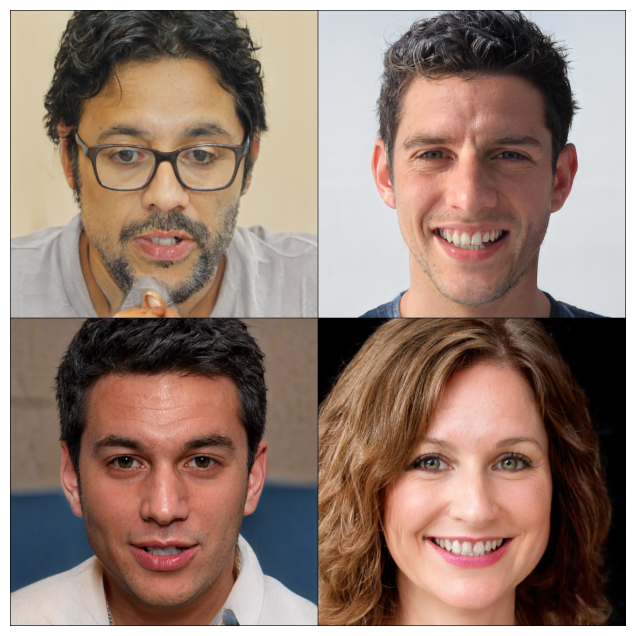

Эпоха 52: loss=0.5981
Эпоха 53: loss=0.6470
Эпоха 54: loss=0.6133
Эпоха 55: loss=0.6021
Эпоха 56: loss=0.6201
Эпоха 57: loss=0.6113
Эпоха 58: loss=0.6211
Эпоха 59: loss=0.5977
Эпоха 60: loss=0.5889
Эпоха 61: loss=0.6094
Эпоха 62: loss=0.5918
Эпоха 63: loss=0.6016
Эпоха 64: loss=0.5884
Эпоха 65: loss=0.5835
Эпоха 66: loss=0.5923
Эпоха 67: loss=0.5957
Эпоха 68: loss=0.5986
Эпоха 69: loss=0.5933
Эпоха 70: loss=0.5957
Эпоха 71: loss=0.6001
Эпоха 72: loss=0.5869
Эпоха 73: loss=0.5840
Эпоха 74: loss=0.6089
Эпоха 75: loss=0.5903
Эпоха 76: loss=0.5884
Эпоха 77: loss=0.6060
Эпоха 78: loss=0.5884
Эпоха 79: loss=0.5889
Эпоха 80: loss=0.5811
Эпоха 81: loss=0.5889
Эпоха 82: loss=0.5547
Эпоха 83: loss=0.5713
Эпоха 84: loss=0.5820
Эпоха 85: loss=0.5684
Эпоха 86: loss=0.6123
Эпоха 87: loss=0.5747
Эпоха 88: loss=0.6030
Эпоха 89: loss=0.5781
Эпоха 90: loss=0.5645
Эпоха 91: loss=0.5723
Эпоха 92: loss=0.6133
Эпоха 93: loss=0.5547
Эпоха 94: loss=0.5811
Эпоха 95: loss=0.5718
Эпоха 96: loss=0.5557
Эпоха 97: 

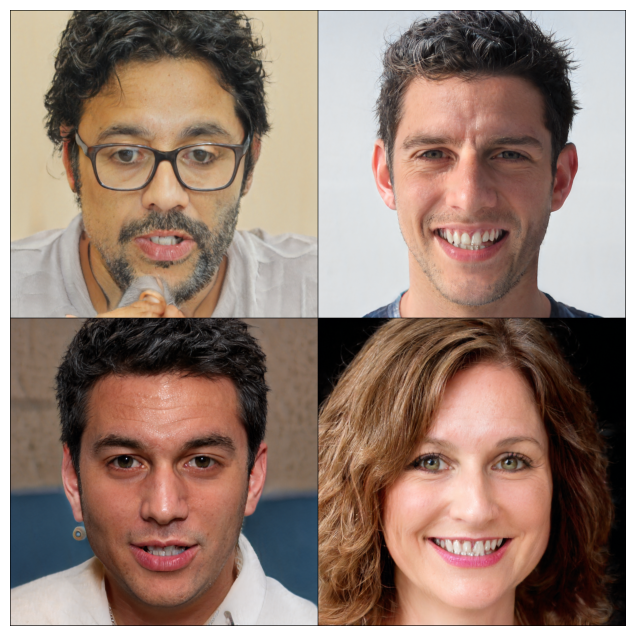

Эпоха 102: loss=0.5508
Эпоха 103: loss=0.5811
Эпоха 104: loss=0.5337
Эпоха 105: loss=0.5845
Эпоха 106: loss=0.5698
Эпоха 107: loss=0.5596
Эпоха 108: loss=0.5659
Эпоха 109: loss=0.5239
Эпоха 110: loss=0.5718
Эпоха 111: loss=0.5864
Эпоха 112: loss=0.5259
Эпоха 113: loss=0.5762
Эпоха 114: loss=0.5312
Эпоха 115: loss=0.5742
Эпоха 116: loss=0.5322
Эпоха 117: loss=0.6050
Эпоха 118: loss=0.5229
Эпоха 119: loss=0.5601
Эпоха 120: loss=0.5400
Эпоха 121: loss=0.5352
Эпоха 122: loss=0.5420
Эпоха 123: loss=0.5190
Эпоха 124: loss=0.5317
Эпоха 125: loss=0.5176
Эпоха 126: loss=0.5381
Эпоха 127: loss=0.5444
Эпоха 128: loss=0.5044
Эпоха 129: loss=0.5410
Эпоха 130: loss=0.5649
Эпоха 131: loss=0.5371
Эпоха 132: loss=0.5557
Эпоха 133: loss=0.5225
Эпоха 134: loss=0.5249
Эпоха 135: loss=0.5405
Эпоха 136: loss=0.5244
Эпоха 137: loss=0.5356
Эпоха 138: loss=0.5171
Эпоха 139: loss=0.5093
Эпоха 140: loss=0.5127
Эпоха 141: loss=0.5107
Эпоха 142: loss=0.5278
Эпоха 143: loss=0.4993
Эпоха 144: loss=0.5083
Эпоха 145: 

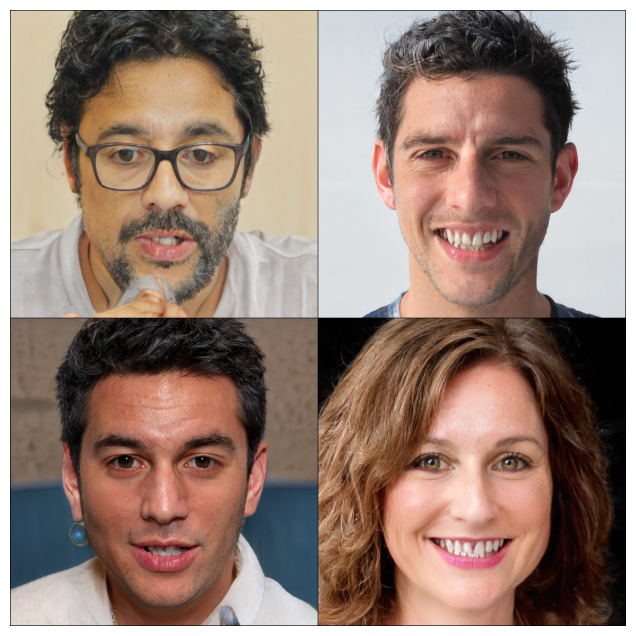

Эпоха 152: loss=0.5249
Эпоха 153: loss=0.5186
Эпоха 154: loss=0.5278
Эпоха 155: loss=0.4980
Эпоха 156: loss=0.5503
Эпоха 157: loss=0.5078
Эпоха 158: loss=0.5337
Эпоха 159: loss=0.5356
Эпоха 160: loss=0.4988
Эпоха 161: loss=0.5269
Эпоха 162: loss=0.4900
Эпоха 163: loss=0.5005
Эпоха 164: loss=0.5396
Эпоха 165: loss=0.5122
Эпоха 166: loss=0.4993
Эпоха 167: loss=0.5498
Эпоха 168: loss=0.4922
Эпоха 169: loss=0.5088
Эпоха 170: loss=0.4917
Эпоха 171: loss=0.4915
Эпоха 172: loss=0.5127
Эпоха 173: loss=0.4829
Эпоха 174: loss=0.5371
Эпоха 175: loss=0.4802
Эпоха 176: loss=0.5059
Эпоха 177: loss=0.4917
Эпоха 178: loss=0.4736
Эпоха 179: loss=0.4775
Эпоха 180: loss=0.4736
Эпоха 181: loss=0.4844
Эпоха 182: loss=0.4846
Эпоха 183: loss=0.5000
Эпоха 184: loss=0.4866
Эпоха 185: loss=0.4875
Эпоха 186: loss=0.4871
Эпоха 187: loss=0.4875
Эпоха 188: loss=0.5425
Эпоха 189: loss=0.4624
Эпоха 190: loss=0.5127
Эпоха 191: loss=0.4795
Эпоха 192: loss=0.5054
Эпоха 193: loss=0.4976
Эпоха 194: loss=0.4556
Эпоха 195: 

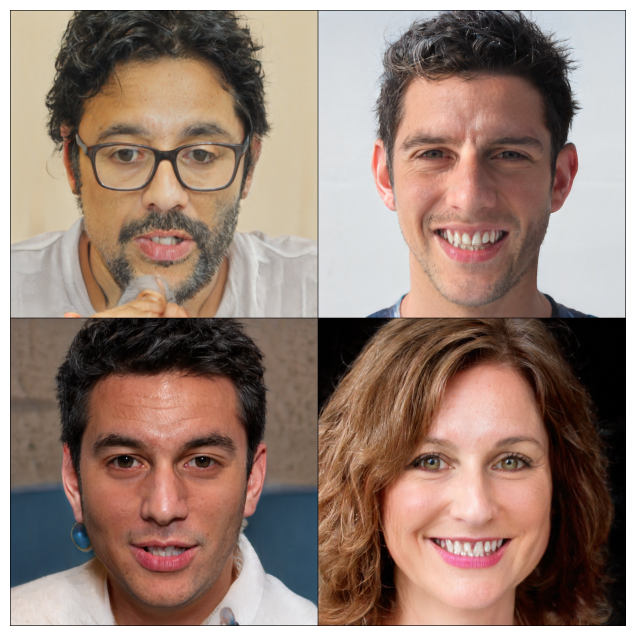

Эпоха 202: loss=0.4646
Эпоха 203: loss=0.4758
Эпоха 204: loss=0.5137
Эпоха 205: loss=0.4551
Эпоха 206: loss=0.4795


KeyboardInterrupt: 

In [16]:
train_generator(generator=G,
                generator_frozen=G_frozen,
                model=model,
                preprocess_image=preprocess,
                text_source='human',
                text_target='werewolf',
                epochs=301,
                criterion=clip_loss,
                device=device,
                lr=0.005,
                lr_w=0.02,
                k=12,
                lambda_reg=0.01,
                max_norm=2.0,
                c=None)